In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
sns.set()
sns.set_style('whitegrid')

In [3]:
df = pd.read_csv('data/cycles-with-features.csv', header=0).drop(labels='Unnamed: 0', axis=1)

### Fourier analysis
We approximate the 47 training cycles with a sum of sinusoidal cycles. In this case, the discrete fourier transform (DFT) reveals periodicity in input data, which is valuable since the period of each cycle varies over time. DFT is vulnerable to aliasing. The fourier transform of the original signal $ f(t) $ takes the form
$$ F(jw) = \int_{-\infty}^{\infty} f(t)e^{-j\omega t}dt $$

In [4]:
pd.options.mode.chained_assignment = None
sample = df

In [ ]:
#sample = df[::2]
sample['DFT'] = np.abs(np.fft.fft(sample['Load'].values))
sample['FREQ'] = np.fft.fftfreq(sample['DFT'].shape[0], 0.1*5)

### Interpreting the Fourier analysis
We subsample every 5 values for speed. The most intense signals in our 47 cycles occur in the low-frequency domain. From top-left to bottom-right clockwise, we observe plots for: log-intensity against frequency; log-intensity against frequency in the $0-1Hz$ domain, since intensity roughly reflects at $freq=0$; signal intensity against $(0.1s)$ frequency; and a histogram of signal intensity, which expectedly shows that low-intensity signals occur most densely. Spikes at roughly $0.55Hz$ and $0.9Hz$ also reveal high-intensity signals. [Refer to this for more information](https://nipunbatra.github.io/blog/2016/FT.html).

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 10)); axes.flat[0].set(yscale="log"); axes.flat[1].set_xlim(0, 1); axes.flat[1].set(yscale="log")
sns.regplot('FREQ', 'DFT', sample, ax=axes.flat[0], fit_reg=False, scatter_kws={'s':2, 'alpha':0.5})
sns.regplot('FREQ', 'DFT', sample, ax=axes.flat[1], fit_reg=False, scatter_kws={'s':2, 'alpha':0.5});
#sns.distplot(sample['DFT'].values, bins=30, kde=False, ax=axes.flat[2]); sns.regplot('FREQ', 'DFT', sample, ax=axes.flat[3], fit_reg=False, scatter_kws={'s':2, 'alpha':0.5})

In [ ]:
fig.savefig('images/fourier-analysis.png')

### Fourier extrapolation
We can now use patterns found via Fourier analysis to extrapolate future cycles.

In [ ]:
def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 100                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 3)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = np.fft.fft(x_notrend)  # detrended x in frequency domain
    #x_freqdom = np.fft.fft(x)  # detrended x in frequency domain
    f = np.fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

In [ ]:
def fourier_extrapolate(sample, n_pred, n_harm): # n_pred = points to predict; n_harm = number of harmonics
    t = np.arange(0, sample.shape[0]+n_pred)
    sig = np.zeros(t.size)
    for i in range(n_harm):
        amp = np.absolute(sample['DFT'].iloc[i])
        phase = np.angle(sample['DFT'].iloc[i])
        sig += amp * np.cos(2*np.pi*sample['FREQ'].iloc[i]*t + phase)
    return sig

In [ ]:
fig, axes = plt.subplots(figsize=(20,5))
n_pred = 2000
ext = fourierExtrapolation(sample['Load'].values, n_pred)
#ext = fourier_extrapolate(sample, n_pred, 10000)
plt.scatter(np.arange(0, sample['Time'].shape[0]), sample['Load'].values, s=2, alpha=0.5)
plt.scatter(np.arange(0, sample['Time'].shape[0] + n_pred), ext, s=2, alpha=0.5)

In [ ]:
fig.savefig('images/fourier-extrapolation.png')

### Polynomial interpolation
We naively fit $n$-degree polynomials to a single cycle.

In [ ]:
c = sample[sample['Cycle']==2]

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 10))
degrees = [3, 6, 9, 12]
for i, ax in enumerate(axes.flat):
    fit = np.polyfit(c['Time'].values, c['Load'].values, degrees[i])
    yhat = np.polyval(fit, c['Time'].values)
    c['PCF'] = yhat
    sns.regplot('Time', 'Load', c, ax=axes.flat[i], fit_reg=False, scatter_kws={'s':5, 'alpha': 1.0})
    sns.regplot('Time', 'PCF', c, ax=axes.flat[i], fit_reg=False, scatter_kws={'s':5, 'alpha': 1.0})
    ax.set_title(str(degrees[i]) + '-degrees')

## Evaluating regression on derived features

`{ Linear | Ridge | Lasso } regression` provide us with a performance baseline for predicting derived features, namely `Heating`, `Cooling`, `Area`, `Tail`, `Belly`.

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [59]:
df[df['Min']==1].head()

,Time,Load,Datetime,Min,Max,Cycle,Area,Heating,Cooling,HCprop,Period,Tail,Belly
18,1.70000,-0.10153,1970-01-01 00:00:01.700000000,1,0,1,0.000000,0.00000,0.00000,NaN,0.00000,0.00000,0.000000
2676,262.30000,-0.09963,1970-01-01 00:04:22.300000000,1,0,2,7194.644662,85.80000,174.69997,0.491128,260.49997,174.59997,3791.874181
5844,573.89994,0.00872,1970-01-01 00:09:33.899940000,1,0,3,8131.923440,58.50000,253.00000,0.231225,311.50000,252.90000,3574.821393
9224,906.69994,-0.05600,1970-01-01 00:15:06.699940000,1,0,4,8249.843636,63.00000,269.70006,0.233593,332.70006,269.60000,3361.284154
12528,1231.90000,-0.00150,1970-01-01 00:20:31.900000000,1,0,5,8198.216090,60.90006,264.19988,0.230508,325.09994,264.09994,3435.771394


In [94]:
n_splits = 10
clfs = [LinearRegression(), Ridge(), Lasso(), ElasticNet()]
tscv = TimeSeriesSplit(n_splits=n_splits)
cols = ['Time', 'Load', 'Cycle', 'Heating', 'Cooling', 'Tail', 'Belly']
sample = df.dropna(axis=0, how='any').reset_index()
X = sample[cols]
y = sample['Area']

In [95]:
scores = [[], [], [], []]
for train_index, test_index in tscv.split(X):
    # Train-test split for time-series (non-iid) data
    X_train, X_test, y_train, y_test = X.iloc[train_index, :], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    for i, clf in enumerate(clfs):
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        scores[i].append(max(0, score))
scores = pd.DataFrame(scores).T
scores.columns = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'ElasticNet']

/home/nwchen/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


### Regression model accuracy on `Area` over various cross-validation splits
We evaluate the performance of several simple linear regression approaches to predicting `Area`.

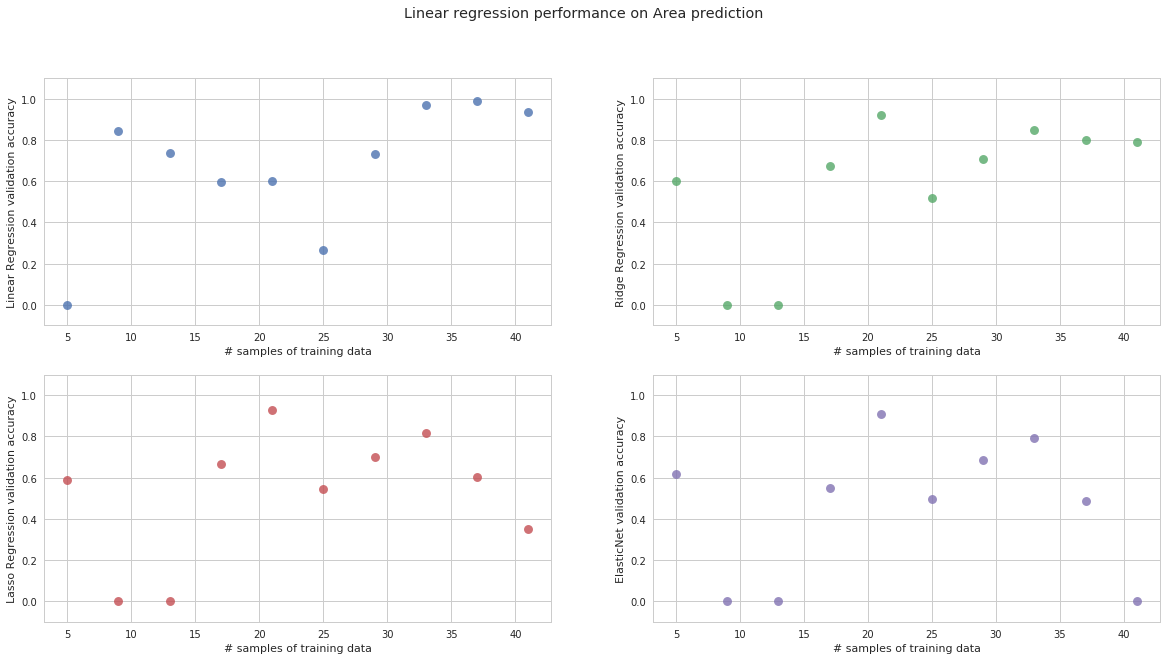

In [103]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
for i, clf in enumerate(clfs):
    axes.flat[i].set_ylim(-0.1, 1.1)
    sns.regplot(pd.Series(np.arange(5, 45, 4)), scores.columns[i], scores, fit_reg=False, ax=axes.flat[i], scatter_kws={'s': 80})
    axes.flat[i].set_xlabel('# samples of training data')
    axes.flat[i].set_ylabel(scores.columns[i] + ' validation accuracy')
fig.suptitle('Linear regression performance on Area prediction')
fig.savefig('images/linear-performance.png')

### Polynomial-feature/linear regression pipeline with time-series cross-validation over $ \frac{train}{test} $

In [104]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [105]:
X = sample[cols]
y = sample['Area']

In [106]:
pclfs = [LinearRegression(), Ridge(), Lasso(), ElasticNet()]
poly_clfs = [make_pipeline(PolynomialFeatures(include_bias=False), clf) for clf in pclfs]
pscores = [[], [], [], []]
for train_index in np.arange(5, 45, 4):
    X_train, X_test, y_train, y_test = X.iloc[:train_index], X.iloc[train_index:], y.iloc[:train_index], y.iloc[train_index:]
    for i, poly in enumerate(poly_clfs):
        poly.fit(X_train, y_train)
        pscores[i].append(max(0, poly.score(X_test, y_test)))
pscores = pd.DataFrame(pscores).T
pscores.columns = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'ElasticNet']

/home/nwchen/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/nwchen/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/nwchen/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/nwchen/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You 

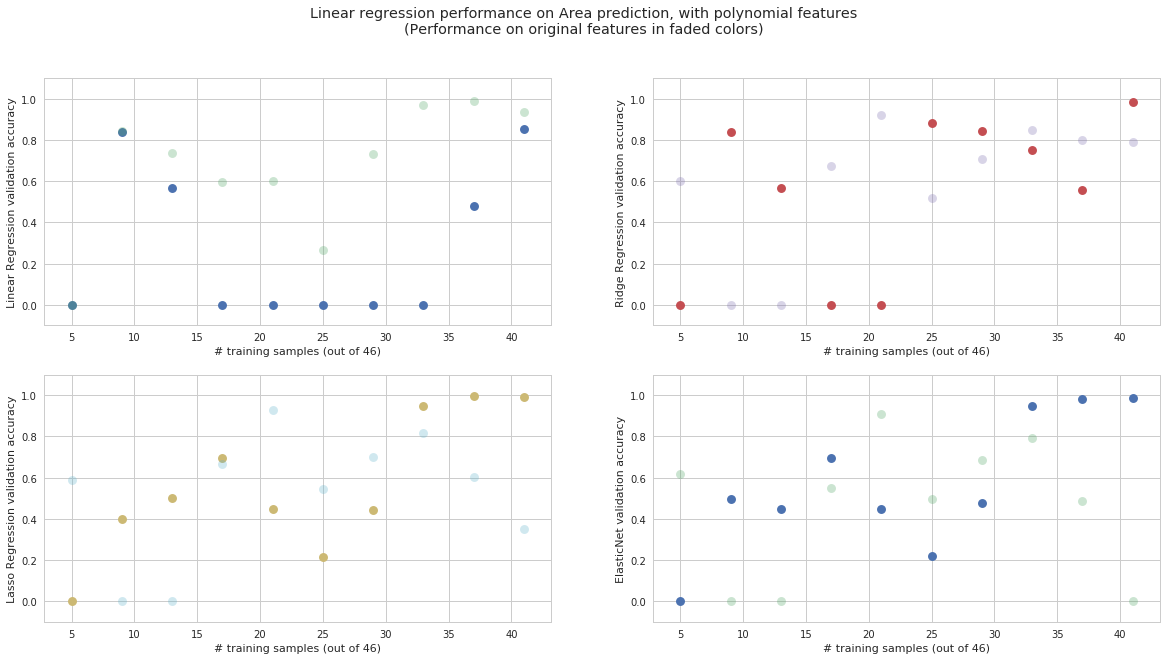

In [98]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
for i, pclf in enumerate(scores.columns):
    sns.regplot(np.arange(5, 45, 4), pclf, pscores, fit_reg=False, ax=axes.flat[i], scatter_kws={'s': 80, 'alpha': 1.0})
    sns.regplot(np.arange(5, 45, 4), scores.columns[i], scores, fit_reg=False, ax=axes.flat[i], scatter_kws={'s': 80, 'alpha': 0.3}) # original (non-polynomial features)
    axes.flat[i].set_xlabel('# training samples (out of 46)')
    axes.flat[i].set_ylabel(pclf + ' validation accuracy')    
    axes.flat[i].set_ylim(-0.1, 1.1)
fig.suptitle('Linear regression performance on Area prediction, with polynomial features\n(Performance on original features in faded colors)')
fig.savefig('images/polylinear-pipeline-performance.png')

#### We observe that simple regression models' performance does not significantly increase, even when trained to interpret polynomial features.

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
for i, clf in enumerate(clfs.keys()):
    y = pd.Series(clfs[clf]); y[y<0] = 0
    sns.regplot(pd.Series(np.linspace(5, 45, 10)), y, fit_reg=False, ax=axes.flat[i])
    axes.flat[i].set_xlabel('# samples of training data')
    clf_name = str(clf)[: str(clf).find('(')]
    axes.flat[i].set_ylabel(clf_name + ' performance on test samples')
fig.savefig('images/polylinear-performance.png')

### KNN-regression does not perform well either.

In [30]:
from sklearn.neighbors import KNeighborsRegressor

In [32]:
knnr = KNeighborsRegressor()
knnr.fit(X_train, y_train)
knnr.score(X_test, y_test)

-9.340843787812215

### Kernel-SVM (nonlinear)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR

In [ ]:
cols = ['Time', 'Load', 'Cycle', 'Heating', 'Cooling', 'Tail', 'Belly']
sample = df.dropna(axis=0, how='any').reset_index()
X = sample[cols]
y = sample['Area']

In [ ]:
svr_rbf = SVR(kernel='rbf', cache_size=7000, C=100, gamma=0.1, epsilon=.1)
y_rbf = svr_rbf.fit(X, y).predict(X)

In [ ]:
toydf = sample.iloc[:12, :]
X, y = toydf[cols], toydf['Area']

In [ ]:
svr_poly = SVR(kernel='poly', cache_size=7000, C=100, degree=3, epsilon=1, coef0=1)
y_poly = svr_poly.fit(X, y).predict(X)

_Maybe one day, this will finish running._

In [ ]:
y_poly

In [ ]:
fig, axes = plt.subplots()
sns.regplot(X['Cycle'], y_poly, ax=axes, scatter_kws={'alpha':0.3})
sns.regplot(X['Cycle'], toydf['Area'], ax=axes, scatter_kws={'alpha':0.3})